In [8]:
"""
Author: Valentina Matos (Johns Hopkins - Wirtz/Kiemen Lab)
Date: June 22, 2024
"""
import os
import numpy as np
import warnings
from save_model_metadata import save_model_metadata
from load_annotation_data import load_annotation_data
from train_segmentation_model import train_segmentation_model
from create_training_tiles import create_training_tiles
from test_segmentation_model import test_segmentation_model
from classify_images import classify_images
import sys
from PySide6 import QtWidgets
from CODAGUI_fend import MainWindow
# from WSI2tif import WSI2tif
warnings.filterwarnings("ignore")

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
# Execute the GUI
app = QtWidgets.QApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)

window = MainWindow()
window.show()
app.exec()


Form filled with: 
Training path: //10.99.68.52/Kiemendata/Valentina Matos/tissues for methods paper/human liver
Testing path: //10.99.68.52/Kiemendata/Valentina Matos/tissues for methods paper/human liver/testing image
Model name: 08_15_2024
Resolution: 10x
Loaded XML file: //10.99.68.52/Kiemendata/Valentina Matos/tissues for methods paper/human liver\Liv-17_0001.xml
    Layer Name           Color Whitespace Settings
0         PDAC  (64, 128, 128)                None
1    bile duct   (255, 255, 0)                None
2  vasculature     (255, 0, 0)                None
3   hepatocyte   (255, 0, 255)                None
4       immune       (0, 0, 0)                None
5       stroma  (255, 128, 64)                None
6   whitespace     (0, 0, 255)                None
Color changed for hepatocyte to (170, 85, 127)
Color changed for vasculature to (255, 0, 0)
Color changed for PDAC to (0, 0, 0)
Color changed for PDAC to (255, 170, 127)
Color changed for stroma to (255, 220, 247)
Color c

0

In [12]:
#_______________Variable parametrization from GUI_______________

#Paths
pth = window.ui.trianing_LE.text()
pthtest = window.ui.testing_LE.text()
model_name = window.ui.model_name.text()
resolution = window.ui.resolution_CB.currentText()
pthim = os.path.join(pth, f'{resolution}')
pthDL = os.path.join(pth, model_name)

#Tif resolution
resolution_to_umpix = {"10x": 1, "5x": 2, "16x": 4}
umpix = resolution_to_umpix.get(resolution, 2)  # Default to 2 if resolution not found

# Get the dataframe with annotation information
combined_df = window.combined_df
classNames = combined_df['Combined names'].tolist()
colormap = combined_df['Combined colors'].tolist()

#Training tile size
tile_size = window.tile_size
#Number of training tiles
ntrain = window.ntrain
nvalidate = window.nval
#Number of validations tiles
nval = window.nval
#Number of TA images to evaluate (coming sooon)
# TA = window.TA

#Create WS
df = window.df
layers_to_delete = df.index[~df['Delete layer']].tolist()
layers_to_delete = [i+1 for i in layers_to_delete] #get row index starting from 1
nesting_list = df['Nesting'].tolist()
nesting_list.reverse()
WS = [df['Whitespace Settings'].tolist(),
      [window.add_ws_to, window.add_nonws_to],
      df['Combined layers'].tolist(),
      nesting_list,
      layers_to_delete
      ]


numclass = max(WS[2])
nblack = numclass + 1;nwhite = WS[1][0]

colormap = np.array(colormap)

#Final Parameters
print('Classnames: ', classNames)
print('Colormap: ', colormap)
print(WS)

Classnames:  ['PDAC', 'bile duct', 'vasculature', 'hepatocyte', 'immune', 'stroma', 'whitespace']
Colormap:  [[255 170 127]
 [255 255   0]
 [255   0   0]
 [170  85 127]
 [  0   0   0]
 [255 220 247]
 [255 255 255]]
[[0, 0, 0, 0, 2, 0, 2], [7, 6], [1, 2, 3, 4, 5, 6, 7], [6, 4, 5, 1, 3, 2, 7], []]


Saving model metadata and classification colormap...
Creating Net metadata file...
Plotting cmap took 0.0 minutes and 0.14815878868103027 seconds
Saving metadata took 0.0 minutes and 0.2463243007659912 seconds


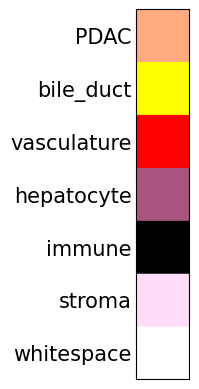

In [13]:
# 1 save model metadata
save_model_metadata(pthDL, pthim, WS, model_name, umpix, colormap, tile_size, classNames, ntrain, nvalidate)

In [ ]:
# Create tif images from /.ndpi / .svs
WSI2tif(pth, resolution, umpix)

In [14]:
# 2 load and format annotations from each annotated image
[ctlist0, numann0] = load_annotation_data(pthDL, pth, pthim)

 
Importing annotation data...
Image 1 of 6: Liv-17_0001
Checking parameters took 0.0 minutes and 0.0 seconds
 1. of 4. Importing annotation data from xml file
Loading annotation took 0.0 minutes and 0.3515191078186035 seconds
 Creating file...
Import xml took 0.0 minutes and 0.38153576850891113 seconds
  Existing TA loaded
Calculating tissue mask took 0.0 minutes and 25.158158779144287 seconds
 2. of 4. Interpolating annotated regions and saving mask image
Format white took 0.0 minutes and 41.23377251625061 seconds
Saving annotation mask took 2.0 minutes and 34.593748807907104 seconds
 4. of 4. Creating bounding box tiles of all annotations
Bounding boxes took 0.0 minutes and 24.523181676864624 seconds
 Finished image in 224 seconds.
Image 2 of 6: Liv-17_0041
Checking parameters took 0.0 minutes and 0.0010001659393310547 seconds
 1. of 4. Importing annotation data from xml file
Loading annotation took 0.0 minutes and 0.1887073516845703 seconds
 Creating file...
Import xml took 0.0 min

In [15]:
# 3 Make training & validation tiles for model training
create_training_tiles(pthDL, numann0, ctlist0)


Calculating total number of pixels in the training dataset...
 There are 544424200.0 pixels of PDAC, 41% of the most common class.
 There are 32237300.0 pixels of bile duct, 2% of the most common class.
 There are 92535400.0 pixels of vasculature, 7% of the most common class.
 There are 1312608300.0 pixels of hepatocyte. This is the most common class.
 There are 32903400.0 pixels of immune, 2% of the most common class.
 There are 655049200.0 pixels of stroma, 49% of the most common class.
 There are 817804400.0 pixels of whitespace, 62% of the most common class.

Building training tiles...
Starting time for the while loop
Saving big tiles
  1 of 15 training images completed in 4 minutes
  Used 136.7% counts and 32.7% unique annotations of PDAC
  Used 586.2% counts and 100.0% unique annotations of bile duct
  Used 433.3% counts and 77.8% unique annotations of vasculature
  Used 277.5% counts and 46.4% unique annotations of hepatocyte
  Used 665.8% counts and 100.0% unique annotations o

In [ ]:
# 4 Train model
train_segmentation_model(pthDL)

TensorFlow is using the following GPU: LogicalDevice(name='/device:GPU:0', device_type='GPU')
Starting model training...
Epoch 1/8


In [24]:
# 5 Test model
pthtestim = os.path.join(pthtest, f'{resolution}')
# WSI2tif(pthtest, resolution, umpix)
test_segmentation_model(pthDL, pthtest, pthtestim)

Testing segmentation model......
 
Importing annotation data...
Image 1 of 2: SG_013_0013
Checking parameters took 0.0 minutes and 0.0009999275207519531 seconds
 1. of 4. Importing annotation data from xml file
Loading annotation took 0.0 minutes and 2.049485445022583 seconds
 Creating file...
Import xml took 0.0 minutes and 2.163480758666992 seconds
  Calculating TA image
Calculating tissue mask took 0.0 minutes and 11.63170576095581 seconds
 2. of 4. Interpolating annotated regions and saving mask image
Format white took 0.0 minutes and 23.36711549758911 seconds
Saving annotation mask took 1.0 minutes and 23.94567584991455 seconds
 4. of 4. Creating bounding box tiles of all annotations
Bounding boxes took 0.0 minutes and 23.464845180511475 seconds
 Finished image in 127 seconds.
Image 2 of 2: SG_014_0016
Checking parameters took 0.0 minutes and 0.0009999275207519531 seconds
 1. of 4. Importing annotation data from xml file
Loading annotation took 0.0 minutes and 1.3741555213928223 s

KeyError: 'model'

In [ ]:
# 6 Classify images with pretrained model
classify_images(pthim,pthDL)